# Computer Assignment 3: Pyramid Transforms
## Alaqian Zafar - aaz7118

In this assignment, you will implement 2D Gaussian, Laplacian pyramids and a Wavelet transform in Python, and look at their reconstruction qualities and representation efficiency.

You'll need to have python packages for `OpenCV`  and `PyWavelets` installed. Throughout the following problems, keep your input images on the `uint8` scale of [0,255].


## Table of Contents
- <a href='#p1'>**Problem 1** (Gaussian and Laplacian pyramids)</a>
    - <a href='#p1a'>**Problem 1** (a)</a>
    - <a href='#p1b'>**Problem 1** (b)</a>
    - <a href='#p1c'>**Problem 1** (c)</a>
    - <a href='#p1d'>**Problem 1** (d)</a>
- <a href='#p2'>**Problem 2** (Wavelet Transform)</a>
    - <a href='#p2a'>**Problem 2** (a)</a>
    - <a href='#p2b'>**Problem 2** (b)</a>
    - <a href='#p2c'>**Problem 2** (c)</a>
    - <a href='#p2d'>**Problem 2** (d)</a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

<a id='p1'></a>

## **Problem 1** (Gaussian and Laplacian pyramids).

<a id='p1a'></a>
### (a)
Write functions `gaussian_pyramid` and `laplacian_pyramid` that decompose an input grayscale image into a *J*-level Gaussian and Laplacian pyramid, respectively, where *J* is an input to each function.

You can use `cv2.resize` for downsampling and upsampling with `INTER_LINEAR` and
`INTER_CUBIC` filters, respectively.

[Table of Contents](#Table-of-Contents)

In [2]:
def gaussian_pyramid(image, j_levels):
    if j_levels < 0:
        raise ValueError("The 'J-level' parameter must be non-negative.")
    # convert to float
    image_down = image.astype('float')
    gaussian = [image_down]
    for j_level in range(j_levels):
        cols, rows = image_down.shape
        if cols < 2 or rows < 2:
            break
        image_down = cv2.pyrDown(image_down, dstsize=(rows // 2, cols // 2))
        gaussian.append((image_down))
    return gaussian
    
def laplacian_pyramid(image, j_levels):
    gaussian = gaussian_pyramid(image, j_levels)
    laplacian = []
    for j_level in range(len(gaussian) - 1):
        cols, rows = gaussian[j_level].shape
        image_up = cv2.pyrUp(gaussian[j_level+1], dstsize=(rows, cols))
        laplacian.append(gaussian[j_level] - image_up)
    laplacian.append(gaussian[-1])
    return laplacian, gaussian

<a id='p1b'></a>
### (b)
Write a function `reconstruct_laplacian` that reconstructs the original image from a *J*-level Laplacian pyramid. Verify it works correctly on a test image. Display the Gaussian and Laplacian pyramid images for *J* = 3.

[Table of Contents](#Table-of-Contents)

In [3]:
def reconstruct_laplacian(laplacian):
    image = laplacian[-1]
    for j in range(2, len(laplacian)+1):
        cols, rows = laplacian[-j].shape
        image = laplacian[-j] + cv2.pyrUp(image, dstsize = (rows,cols))
    return image

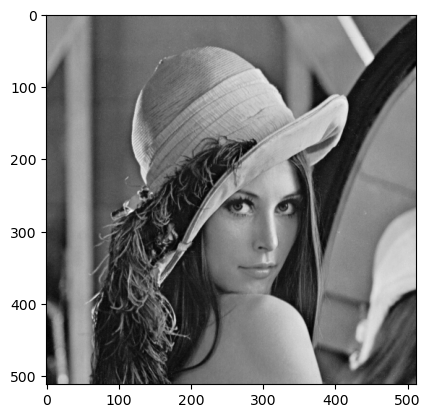

In [4]:
# Test the image
image = cv2.imread('lena_gray.bmp', 0)
l,g = laplacian_pyramid(image, 3)
image_reconstruct = reconstruct_laplacian(l);
plt.figure(); 
plt.imshow(image_reconstruct, cmap='gray');

247


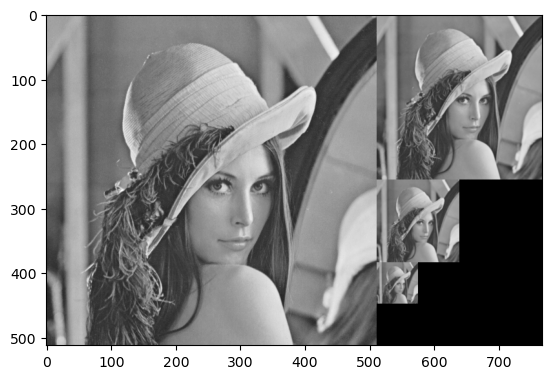

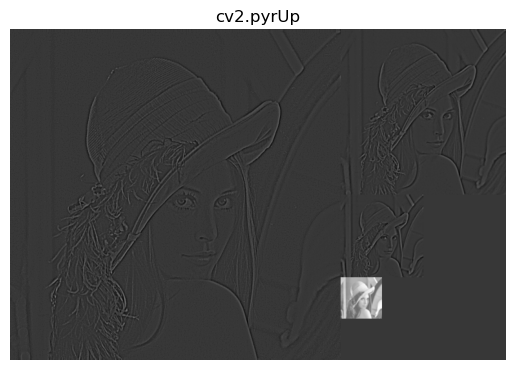

In [5]:
# Expected output
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.transform import pyramid_gaussian, pyramid_laplacian

image = cv2.imread('lena_gray.bmp', 0)
print(image.max())
rows, cols  = image.shape
pyramid = g#tuple(pyramid_gaussian(image, downscale=2))
laplacian = l#tuple(pyramid_laplacian(image, downscale=2))

# determine the total number of rows and columns for the composite
composite_rows = max(rows, sum(p.shape[0] for p in pyramid[1:]))
composite_cols = cols + pyramid[1].shape[1]
composite_image = np.zeros((composite_rows, composite_cols),
                           dtype=np.double)
laplacian_image = np.zeros((composite_rows, composite_cols),
                           dtype=np.double)

# store the original to the left
composite_image[:rows, :cols] = pyramid[0]
laplacian_image[:rows, :cols] = laplacian[0]
# stack all downsampled images in a column to the right of the original
i_row = 0
for p,q in zip(pyramid[1:], laplacian[1:]):
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    laplacian_image[i_row:i_row + n_rows, cols:cols + n_cols] = q
    i_row += n_rows

    
#laplacian_image = laplacian_image / laplacian_image.max() * 255
#laplacian_image = ( laplacian_image - laplacian_image.min() ) / ( laplacian_image.max() - laplacian_image.min() ) * 255
#np.clip(laplacian_image, 0, 255, out=laplacian_image)
#laplacian_image = laplacian_image
    
plt.figure()
plt.imshow(composite_image, cmap='gray')
plt.show()

plt.figure()
plt.imshow(laplacian_image, cmap='gray')
plt.title('cv2.pyrUp')
plt.axis('off')
plt.show()

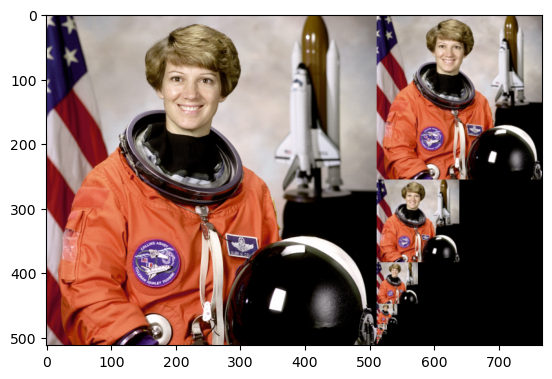

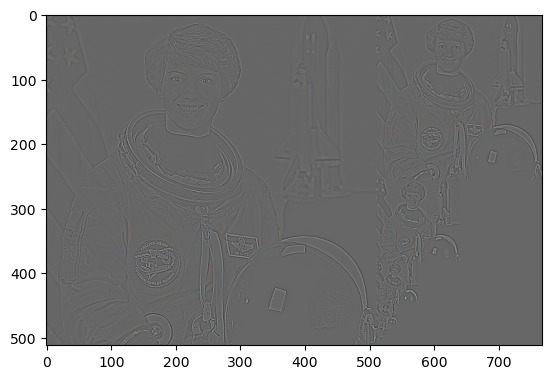

In [6]:
# Expected output
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.transform import pyramid_gaussian, pyramid_laplacian


image = data.astronaut()
#image = cv2.imread('lena_color.tiff')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
rows, cols, dim = image.shape
pyramid = tuple(pyramid_gaussian(image, downscale=2, channel_axis=-1))
laplacian = tuple(pyramid_laplacian(image, downscale=2, channel_axis=-1))

# determine the total number of rows and columns for the composite
composite_rows = max(rows, sum(p.shape[0] for p in pyramid[1:]))
composite_cols = cols + pyramid[1].shape[1]
composite_image = np.zeros((composite_rows, composite_cols, 3),
                           dtype=np.double)
laplacian_image = np.zeros((composite_rows, composite_cols, 3),
                           dtype=np.double)

# store the original to the left
composite_image[:rows, :cols, :] = pyramid[0]
laplacian_image[:rows, :cols, :] = laplacian[0]
# stack all downsampled images in a column to the right of the original
i_row = 0
for p,q in zip(pyramid[1:], laplacian[1:]):
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    laplacian_image[i_row:i_row + n_rows, cols:cols + n_cols] = q
    i_row += n_rows

# laplacian_image = laplacian_image / laplacian_image.max() * 255
laplacian_image = ( laplacian_image - laplacian_image.min() ) / ( laplacian_image.max() - laplacian_image.min() ) * 255
np.clip(laplacian_image, 0, 255, out=laplacian_image)
laplacian_image = laplacian_image.astype('uint8')
    
plt.figure()
plt.imshow(composite_image)
plt.show()

plt.figure()
plt.imshow(laplacian_image)
plt.show()

<a id='p1c'></a>
### (c)

[Table of Contents](#Table-of-Contents)

<a id='p1d'></a>
### (d)

[Table of Contents](#Table-of-Contents)

<a id='p2'></a>

## **Problem 2** ()

<a id='p2a'></a>
### (a)

[Table of Contents](#Table-of-Contents)

<a id='p2b'></a>
### (b)

[Table of Contents](#Table-of-Contents)

<a id='p2c'></a>
### (c)

[Table of Contents](#Table-of-Contents)

<a id='p2d'></a>
### (d)

[Table of Contents](#Table-of-Contents)